# City initialization and methods

In [1]:
import os
import pandas as pd
import geopandas as gpd

local_crs = 32636
example_data_path = "./data"

## Initialization

Use the results obtained from the ``blocksnet.preprocessing`` or use your own data.

In [2]:
blocks = gpd.read_file(os.path.join(example_data_path, "blocks_pzz.geojson"))
adjacency_matrix = pd.read_pickle(os.path.join(example_data_path, "adjacency_matrix.pickle"))

In [3]:
from blocksnet.models import City

city_model = City(
  blocks=blocks.rename(columns={'landuse_1':'land_use'}), 
  adj_mx=adjacency_matrix, 
) 

Print city model to get the information about existing service types, CRS and blocks count

In [4]:
print(city_model)

CRS : EPSG:32636
Blocks : 3839
Service types : 43
Buildings : 0
Services : 0



## Update layers

Update the information about services and buildings using ``.update_buildings()`` and ``.update_services()``.

It is **IMPORTANT** to update buildings first, because they serve as container for some kinds of services.

Specification for buildings is described in the ``blocksnet.models.city.Building``

In [5]:
buildings = gpd.read_parquet(os.path.join(example_data_path, "platform/buildings.parquet")).to_crs(local_crs)

In [6]:
buildings = buildings.rename(columns={
  'population_balanced': 'population',
  'building_area': 'footprint_area',
})
buildings = buildings.fillna(0)
buildings['storeys_count'] = buildings.apply(
  lambda x : x['storeys_count'] if x['storeys_count']>1 else 1, 
  axis=1
)
buildings['build_floor_area'] = buildings['footprint_area']*buildings['storeys_count']
buildings['business_area'] = buildings['build_floor_area'] - buildings['living_area']

In [7]:
city_model.update_buildings(buildings)

In [8]:
block = city_model[0]
city_model.get_blocks_gdf()[['site_area','population','footprint_area', 'build_floor_area', 'living_area', 'business_area']]

,site_area,population,footprint_area,build_floor_area,living_area,business_area
id,,,,,,
0,168088.624355,2662,29859.700203,111389.954750,70690.700989,40699.253761
1,86521.823883,15,3097.864522,3629.781941,496.809998,3132.971944
2,113131.653987,4040,18603.419632,143972.403137,96196.700195,47775.702942
3,782585.161980,1057,97653.270963,199712.824796,75002.308594,124710.516202
4,7179.515458,0,667.198486,1334.396973,0.000000,1334.396973
...,...,...,...,...,...,...
3834,10924.108965,0,0.000000,0.000000,0.000000,0.000000
3835,120169.231261,0,15.968353,15.968353,0.000000,15.968353
3836,14761.319144,0,0.000000,0.000000,0.000000,0.000000


Specification is described in the ``blocksnet.models.city.Service``

In [9]:
for service_type in city_model.service_types:
  print(service_type.name)
  services_gdf = gpd.read_parquet(os.path.join(example_data_path, f"platform/{service_type.name}.parquet"))
  city_model.update_services(service_type, services_gdf.to_crs(city_model.crs))

school
kindergarten


ValidationError: 3 validation errors for BlockService
area
  Field required [type=missing, input_value={'service_type': ServiceT...481, 'index_right': nan}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.0.1/v/missing
geometry.is-instance[Polygon]
  Input should be an instance of Polygon [type=is_instance_of, input_value=<POINT (352306.037 6635465.285)>, input_type=Point]
    For further information visit https://errors.pydantic.dev/2.0.1/v/is_instance_of
geometry.is-instance[MultiPolygon]
  Input should be an instance of MultiPolygon [type=is_instance_of, input_value=<POINT (352306.037 6635465.285)>, input_type=Point]
    For further information visit https://errors.pydantic.dev/2.0.1/v/is_instance_of

In [11]:
city_model.get_services_gdf().explore()

Upload landuse file for existing blocks to update ``LandUse`` according to ``blocksnet.models.city.LandUseRow``

In [9]:
lu = gpd.read_file(os.path.join(example_data_path, "landuse.geojson"))
city_model.update_land_use(lu)

## Methods and other ways to operate the ``City`` model

Plot city model layers with `.plot()`

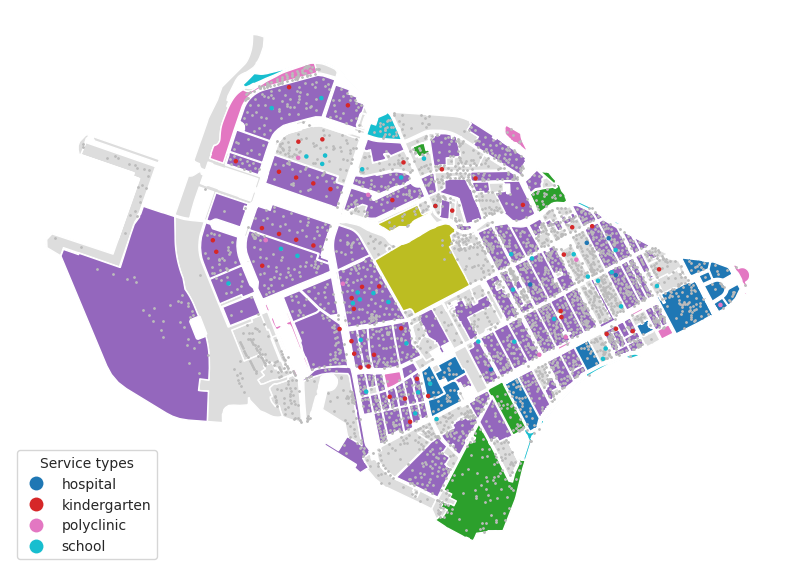

In [10]:
city_model.plot()

Save city model to file with ``.to_pickle()`` so we can use it later

In [10]:
city_model.to_pickle(os.path.join(example_data_path, 'city_model.pickle'))

``Block`` within the city model can be obtained via ``id`` (int)

In [12]:
block = city_model[123]
block

Block(id=123, geometry=<POLYGON ((346460.223 6649125.497, 346465.461 6649128.123, 346465.462 664912...>, land_use=<LandUse.MIXED_USE: 'mixed_use'>, buildings=None, services={}, city=<blocksnet.models.city.City object at 0x7f12698ac670>)

Get available ``ServiceType``s for current ``Block`` ``LandUse``

In [14]:
available_service_types = block.land_use_service_types
[st.name for st in available_service_types]

['school',
 'kindergarten',
 'hospital',
 'polyclinic',
 'pitch',
 'swimming_pool',
 'stadium',
 'theatre',
 'museum',
 'cinema',
 'mall',
 'convenience',
 'supermarket',
 'religion',
 'marketplace',
 'bowling_alley',
 'bank',
 'lawyer',
 'cafe',
 'subway_entrance',
 'hairdresser',
 'restaurant',
 'bar_pub',
 'hotel',
 'post',
 'police']

``ServiceType`` can be obtained the same way by ``name`` (str). The information about accessibility, demand, bricks can be obtained this way.

In [11]:
service_type = city_model['school']
service_type

ServiceType(code='3.5.1', name='school', accessibility=15, demand=120, bricks=[ServiceBrick(capacity=250, area=1.2, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=300, area=1.1, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=600, area=1.3, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=1100, area=1.8, is_integrated=False, parking_area=0.0), ServiceBrick(capacity=250, area=0.2, is_integrated=True, parking_area=0.02), ServiceBrick(capacity=300, area=0.36, is_integrated=True, parking_area=0.03), ServiceBrick(capacity=600, area=0.8, is_integrated=True, parking_area=0.06), ServiceBrick(capacity=1100, area=1.1, is_integrated=True, parking_area=0.1)], land_use=[<LandUse.RESIDENTIAL: 'residential'>, <LandUse.MIXED_USE: 'mixed_use'>, <LandUse.BUSINESS: 'business'>])

Add new ``ServiceType`` to the ``City`` model list

In [13]:
from blocksnet import ServiceType

city_model.add_service_type(ServiceType(code='', name='bakeries', accessibility=30, demand=100, bricks=[]))
city_model['bakeries']

ServiceType(code='', name='bakeries', accessibility=30, demand=100, bricks=[])

Get the distance (min) between two city ``Block``s

In [14]:
city_model.get_distance(0, 1)

9.1

Get blocks ``GeoDataFrame`` via ``.get_blocks_gdf()`` method

In [15]:
blocks_gdf = city_model.get_blocks_gdf()
blocks_gdf.head()

,geometry
id,
0,"POLYGON ((345370.504 6646430.885, 345370.505 6..."
1,"POLYGON ((345254.667 6647047.217, 345254.667 6..."
2,"POLYGON ((345055.642 6646758.330, 345055.643 6..."
3,"POLYGON ((344966.092 6647146.023, 344966.091 6..."
4,"POLYGON ((345082.562 6646776.418, 345082.561 6..."


The same way buildings and services ``GeoDataFrame``s can be obtained with:

- ``.get_buildings_gdf()``
- ``.get_services_gdf()``

In [16]:
buildings_gdf = city_model.get_buildings_gdf()
buildings_gdf.head()

,geometry,population,floors,area,living_area,is_living
0,POINT (345625.313 6646379.081),0.0,0.0,0.0000,0.0,False
1,POINT (345639.028 6646409.751),0.0,1.0,575.4110,0.0,False
2,POINT (345619.009 6646431.188),0.0,1.0,284.8310,0.0,False
3,POINT (345638.596 6646459.785),0.0,1.0,16.2936,0.0,False
4,POINT (345452.265 6646403.874),0.0,7.0,51867.5500,0.0,False


In [17]:
services_gdf = city_model.get_services_gdf()
services_gdf.head()

,geometry,capacity,service_type
0,POINT (344241.473 6648149.216),1200,school
1,POINT (344950.101 6648432.999),1244,school
2,POINT (344780.761 6648505.608),1200,school
3,POINT (345204.730 6649377.764),1200,school
4,POINT (345042.090 6649454.563),1200,school
